In [1]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

/Users/bguenes/miniconda3/envs/master/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prior = utils.BoxUniform(
    low=torch.tensor([-5., -5.]),
    high=torch.tensor([5., 5.])
)

In [3]:
def simulator(mu):
    # Generate samples from N(mu, sigma=0.5)
    return mu + 0.5 * torch.randn_like(mu)

In [4]:
num_sim = 200
method = 'SNRE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    method=method,
    num_simulations=num_sim)

Running 200 simulations.: 100%|██████████| 200/200 [00:00<00:00, 71999.04it/s]


 Neural network successfully converged after 100 epochs.

In [5]:
n_observations = 5
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

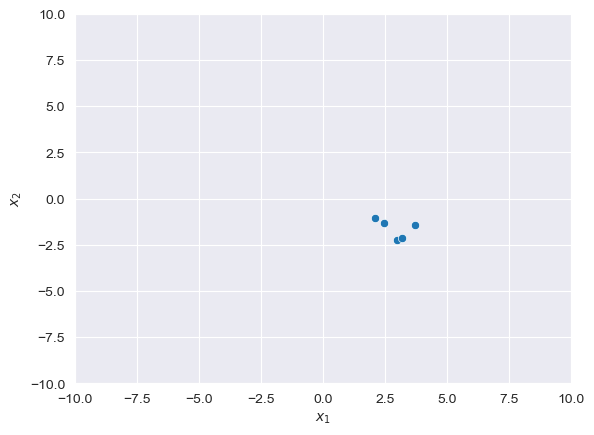

In [15]:
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [16]:
samples = posterior.sample((200,), x=observation[0])

Generating samples: 100%|██████████| 2100/2100 [00:28<00:00, 73.19it/s]


In [2]:
from Chempy.cem_function import single_timestep_chempy

import numpy as np

from sklearn.neural_network import MLPRegressor

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.inference.base import infer
from sbi.analysis import pairplot

#import ili

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import tensorflow as tf

import time as t
import pickle

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
a = ModelParameters()
p = combined_priors.sample((1,))
single_timestep_chempy((p,a))

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [3]:
# ----- Load the Network -----
# Load network weights trained in train_chempyNN.py
x = np.load('data/tutorial_weights.npz')

w0 = x['w0']
w1 = x['w1']
b0 = x['b0']
b1 = x['b1']
in_mean = x['in_mean']
in_std = x['in_std']
out_mean = x['out_mean']
out_std = x['out_std']
activation = x['activation']
neurons = x['neurons']

# --- Load the tensorflow model ---
model = tf.keras.models.load_model('data/tutorial_weights_tf.keras')

In [4]:
# ----- Set-up the Simulator -----
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)
    
    
def simulator_NN_tf(in_par):
    in_par = (in_par - in_mean) / in_std
    in_par = add_time_squared(in_par)

    out = model.predict(in_par, verbose=0)

    return out * out_std + out_mean

In [5]:
# ----- Set-up the Simulator -----
def add_time_squared(x):
    time_squared = np.array([x.T[-1]**2]).T
    if len(x.shape) == 1:
        return np.concatenate((x, time_squared))
    elif len(x.shape) == 2:
        return np.concatenate((x, time_squared), axis=1)


def simulator_NN(in_par):
    in_par = (in_par - in_mean) / in_std
    in_par = add_time_squared(in_par)

    l1 = np.matmul(in_par, w0) + b0
    l2 = np.matmul(np.tanh(l1), w1) + b1

    return l2 * out_std + out_mean

In [6]:
# ----- Set-up priors -----
a = ModelParameters()
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [ ]:
# ----- sbi setup -----
num_sim = 1000
method = 'SNPE' #SNPE or SNLE or SNRE

start = t.time()
posterior = infer(
    simulator_NN_tf,
    combined_priors,
    method=method,
    num_simulations=num_sim)

print(f'Time taken to train the posterior with {num_sim} samples: {round(t.time() - start, 4)}s')

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:18<00:00, 54.36it/s]

: 